# Домашнее задание №4

Это домашнее задание можно выполнять целиком в этом ноутбуке, либо алгоритмы написать в отдельном файле и импортировать сюда, для использования. В папке data лежат два файла islands.fasta и nonIslands.fasta. В них хранятся прочтения из CpG островков и из обычных участков генома соответственно, этими данными нужно будет воспользоваться в первом задании.

## Задача №1 (1)
Определите частоты генерации для каждого из нуклеотидов внутри CpG островков и вне их. Посчитайте так-же частоты для всех упорядоченных пар нуклеотидов и сравните частоту пары CG внутри островков и снаружи. Сделайте вывод. 

In [1]:
from Bio import SeqIO
import numpy as np
import random
import copy
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def load(fname):
    seqs = []
    for record in SeqIO.parse(fname, "fasta"):
        seqs.append(record.seq)
    return seqs

In [3]:
islands = load("data/islands.fasta")
nonislands = load("data/nonIslands.fasta")

In [4]:
len(islands), len(nonislands)

(1828, 1)

In [5]:
print("total islands data length:", sum(map(len, islands)))
print("total nonislands data length:", sum(map(len, nonislands)))

total islands data length: 3656000
total nonislands data length: 212393


In [6]:
def freq_single(seqs, normalize=True):
    cnt = {k:0 for k in "ACGT"}
    for s in seqs:
        for c in s:
            cnt[c] += 1
    if normalize:
        total = sum(cnt.values())
        for k in cnt:
            cnt[k] /= total
    return cnt


def freq_double(seqs, normalize=True):
    cnt = {k:{x:0 for x in "ACGT"} for k in "ACGT"}
    for s in seqs:
        for i in range(len(s) - 1):
            cnt[s[i]][s[i + 1]] += 1
    if normalize:
        for x in cnt:
            total = sum(cnt[x].values())
            for y in cnt[x]:
                cnt[x][y] /= total
    return cnt


def get_log_freq(freq):
    def log_freq_inplace(freq):
        for k in freq:
            if isinstance(freq[k], dict):
                log_freq_inplace(freq[k])
            else:
                freq[k] = np.log(freq[k])
    freq = copy.deepcopy(freq)
    log_freq_inplace(freq)
    return freq

In [7]:
freq_islands = freq_double(islands)

In [8]:
freq_nonislands = freq_double(nonislands)

In [9]:
print("islands CG freq:", freq_islands['C']['G'])
print("nonislands CG freq:", freq_nonislands['C']['G'])

islands CG freq: 0.1989877830473048
nonislands CG freq: 0.026909597196216814


`islands CG freq: 0.1989877830473048 >> nonislands CG freq: 0.026909597196216814`, что и ожидается от CpG островков.

## Задача №2 (2)
Напишите марковскую модель, которая имеет открытые состояния {A, T, G, C}, и скрытые состояния {+, -}. Когда модель в состоянии **+**, то вероятность генерации некоторого символа нуклеотида соответствует его частоте внутри CpG островков, вычислиному в первом задании, если состояние **-**, то частоте вне островков. Вероятность остаться внутри островка 0.95, а перейти в обычный геном 0.05. Для остальной части генома соответствующие вероятности 0.995 и 0.005. Саму модель можно реализовать в виде итератора, определив метод next, который возвращает пару - состояние и нуклеотид, который в этом состоянии произведен.    
Воспользуйтесь данной моделью для того чтобы сгенерировать набор из 20 последовательностей длинной от 1 000 до 100 000, причем к каждой последовательности должна прилагаться последовательность состояний.

In [10]:
def generator_single(freq_islands, freq_nonislands, transition_matrix):
    freq = (freq_nonislands, freq_islands)
    state = random.choice([0, 1])
    cur_freq = freq[state]
    letter, = random.choices(tuple(cur_freq.keys()), tuple(cur_freq.values()))
    while True:
        yield state, letter
        state,  = random.choices([0, 1], transition_matrix[state])
        cur_freq = freq[state]
        letter,  = random.choices(tuple(cur_freq.keys()), tuple(cur_freq.values()))

        
def generator_double(single_freq_islands, single_freq_nonislands,
                     double_freq_islands, double_freq_nonislands,
                     transition_matrix):
    freq = (double_freq_nonislands, double_freq_islands)
    state = np.random.choice([0, 1])
    cur_freq = (single_freq_nonislands, single_freq_islands)[state]
    letter, = random.choices(tuple(cur_freq.keys()), tuple(cur_freq.values()))
    while True:
        yield state, letter
        state, = random.choices([0, 1], transition_matrix[state])
        cur_freq = freq[state][letter]
        letter, = random.choices(tuple(cur_freq.keys()), tuple(cur_freq.values()))

In [11]:
transition_matrix = np.array([[0.005, 0.995], [0.95, 0.05]])
single_freq_islands = freq_single(islands)
single_freq_nonislands = freq_single(nonislands)
double_freq_islands = freq_double(islands)
double_freq_nonislands = freq_double(nonislands)

gen = generator_double(single_freq_islands, single_freq_nonislands,
                       double_freq_islands, double_freq_nonislands,
                       transition_matrix)

In [12]:
random.seed(42)

data = []
n = 20
min_len = 1000
max_len = 100000

for i in range(n):
    gen = generator_double(single_freq_islands, single_freq_nonislands,
                           double_freq_islands, double_freq_nonislands,
                           transition_matrix)
    length = random.randint(min_len, max_len)
    x = []
    pi = []
    for _ in range(length):
        a, b = next(gen)
        pi.append(a)
        x.append(b)
    data.append([x, np.array(pi)])

In [13]:
print("total data length:", sum(map(lambda x: len(x[0]), data)))

total data length: 1057487


## Задача №3 (4)
Напишите алгоритм Витерби для восстановления последовательности скрытых состояний марковской модели из второго задаания. Воспользуйтесь им, воссстановив состояния тех последовательностей, которые вы получили во втором задании и посчитайте TP, TN, FP, FN по количеству правильно или ошибочно предсказанных позиций из CpG остравков. 

In [14]:
def viterbi(x, 
            single_freq_islands, single_freq_nonislands,
            double_freq_islands, double_freq_nonislands,
            transition_matrix, init_pi = (0.5, 0.5)):
    
    n = len(x)
    
    dp = np.zeros((n, 2))
    dp[0, 0] = np.log(single_freq_nonislands[x[0]] * init_pi[0])
    dp[0, 1] = np.log(single_freq_islands[x[0]] * init_pi[1])
    
    log_freq = (get_log_freq(double_freq_nonislands), get_log_freq(double_freq_islands))
    log_transition_matrix = np.log(transition_matrix)
    
    for i in range(1, n):
        for k in (0, 1):
            log_e_k = log_freq[k][x[i - 1]][x[i]]
            dp[i, k] = log_e_k + np.max(dp[i - 1, ...] + log_transition_matrix[..., k])
            
    states = np.zeros(n, dtype=int)
    states[n - 1] = np.argmax(dp[n - 1])
    for i in range(n - 2, -1, -1):
        states[i] = np.argmax(dp[i, ...] + log_transition_matrix[..., states[i + 1]])
    return states

In [15]:
def print_cm(cm):
    print("tn: {}, fp: {}, fn: {}, tp: {}".format(*cm.ravel()))

In [16]:
cm_viterbi = np.zeros((2, 2), dtype=int)
for x, pi in data:
    pi_star = viterbi(x,
                      single_freq_islands, single_freq_nonislands,
                      double_freq_islands, double_freq_nonislands,
                      transition_matrix)
    cm_viterbi += confusion_matrix(pi, pi_star)
print_cm(cm_viterbi)

tn: 401672, fp: 114822, fn: 123384, tp: 417609


## Задача №4 (4)
Напишите алгоритм вперед назад для модели из второго задания. Пользуясь этим алгоритмом найдите вероятности того, что модель находилась в состоянии **+** для каждой позиции строк из второго задания. Устанавливая различные пороговые значения, определите позиции соответствующие CpG островкам и посчитайте TP. Постройте график зависимости TP от выбранного порогового значения. Есть ли пороговые значения при которых TP больше чем в задании №3?

In [17]:
def log_sum_exp(x):
    mx = np.max(x)
    return mx + np.log(np.exp(x - mx).sum())


def forward(x, 
            single_freq_islands, single_freq_nonislands,
            double_freq_islands, double_freq_nonislands,
            transition_matrix, init_pi = (0.5, 0.5)):
    
    n = len(x)
    dp = np.zeros((n, 2))
    dp[0, 0] = np.log(single_freq_nonislands[x[0]] * init_pi[0])
    dp[0, 1] = np.log(single_freq_islands[x[0]] * init_pi[1])

    log_freq = (get_log_freq(double_freq_nonislands), get_log_freq(double_freq_islands))
    log_transition_matrix = np.log(transition_matrix)
    
    for i in range(1, n):
        for k in (0, 1):
            log_e_k = log_freq[k][x[i - 1]][x[i]]
            dp[i, k] = log_e_k + log_sum_exp(dp[i - 1, ...] + log_transition_matrix[..., k])
    return dp


def backward(x, 
            single_freq_islands, single_freq_nonislands,
            double_freq_islands, double_freq_nonislands,
            transition_matrix, init_pi = (0.5, 0.5)):
    
    n = len(x)
    dp = np.zeros((n, 2))
    
    log_freq = (get_log_freq(double_freq_nonislands), get_log_freq(double_freq_islands))
    log_transition_matrix = np.log(transition_matrix)
    
    dp[n - 1, 0] = np.log(init_pi[0])
    dp[n - 1, 1] = np.log(init_pi[1])
    
    for i in range(n - 2, -1, -1):
        for k in (0, 1):
            e_k = np.array([log_freq[t][x[i]][x[i + 1]] for t in (0, 1)])
            dp[i, k] = log_sum_exp(e_k + dp[i + 1, ...] + log_transition_matrix[k, ...])
    
    log_px = log_sum_exp([
        np.log(init_pi[0]) + np.log(single_freq_nonislands[x[0]]) + dp[0, 0],
        np.log(init_pi[1]) + np.log(single_freq_islands[x[0]]) + dp[0, 1]
    ])
    return dp, log_px

In [18]:
scores = []
for x, pi in data:
    log_f = forward(x, single_freq_islands, single_freq_nonislands,
        double_freq_islands, double_freq_nonislands,
        transition_matrix, init_pi=(0.5, 0.5))
    log_b, log_px = backward(x, single_freq_islands, single_freq_nonislands,
            double_freq_islands, double_freq_nonislands,
            transition_matrix, init_pi=(0.5, 0.5))
    log_score = log_f + log_b - log_px
    scores.append(np.exp(log_score))
    assert np.allclose(scores[-1].sum(1), 1)

In [19]:
m = 21

thresholds = np.linspace(0, 1, m)
cm_fb = np.zeros((m, 2, 2))

for i, t in enumerate(thresholds):
    for (_, pi), score in zip(data, scores):
        pi_star = score[..., 1] > t
        cm_fb[i] += confusion_matrix(pi, pi_star)

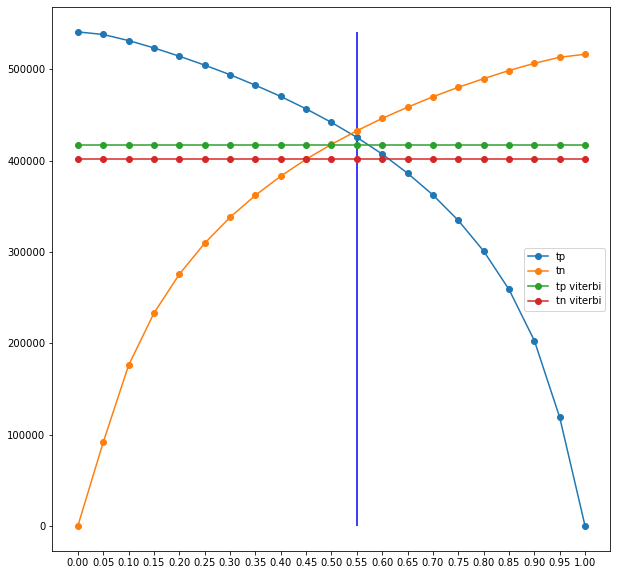

In [20]:
plt.figure(figsize=(10, 10))
plt.plot(thresholds, cm_fb[..., 1, 1], "o-", label="tp")
plt.plot(thresholds, cm_fb[..., 0, 0], "o-", label="tn")
plt.plot(thresholds, [cm_viterbi[1, 1]] * m, "o-", label="tp viterbi")
plt.plot(thresholds, [cm_viterbi[0, 0]] * m, "o-", label="tn viterbi")
plt.xticks(thresholds)
plt.vlines(0.55, 0, cm_fb[0, 1, 1], "b")
plt.legend();

In [21]:
print("forward backward")
threshold = 0.55
cm = np.zeros((2, 2), dtype=int)
for (_, pi), score in zip(data, scores):
    pi_star = score[..., 1] > threshold
    cm += confusion_matrix(pi, pi_star)
print_cm(cm)

forward backward
tn: 432728, fp: 83766, fn: 115408, tp: 425585


In [22]:
print("viterbi")
cm = np.zeros((2, 2), dtype=int)
for x, pi in data:
    pi_star = viterbi(x,
                      single_freq_islands, single_freq_nonislands,
                      double_freq_islands, double_freq_nonislands,
                      transition_matrix)
    cm += confusion_matrix(pi, pi_star)
print_cm(cm)

viterbi
tn: 401672, fp: 114822, fn: 123384, tp: 417609


`forward backward` с порогом `0.55` работает лучше, чем `viterbi` (и по `tp` и по `tn`), так же есть возможность выбирать какие `tp, tn` нас устраивают больше в конкретном случае.